#### Analysis of the ASC


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy import optimize

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs
import random

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

In [3]:
# Load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)

In [4]:
# Read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<AxesSubplot:>

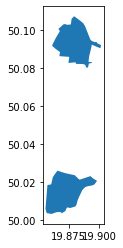

In [ ]:
# Read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
# transform coordinate system to EPSG:4326
gdf_areas = gdf_areas.to_crs(4326) 
# gdf_areas.plot()

In [6]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [7]:
# Read ODMs and calculate the "probabilities" for destinations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate destination "probability" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [8]:
# Read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city zone
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

In [9]:
df_demo.head(2)

,x,y,address,total,zone_NO
0,19.996604,50.086510,STANISŁAWA SKARŻYŃSKIEGO 9,975,147.0
1,20.014369,50.083876,OSIEDLE KOŚCIUSZKOWSKIE 6,955,234.0


In [10]:
# Chosen hub locations for each area
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

Evaluate average ASC for both areas in 30 replications (N = 30)

In [ ]:
results = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                       degree=6, N=30, max_iter=0, ASC=None, results_period=0)

In [ ]:
ascs_b = results['Bronowice Wielkie']['asc_res']
ascs_s = results['Skotniki']['asc_res']
print("avg ASC for Bronowice:", sum(ascs_b) / len(ascs_b), "\navg ASC for Skotniki:", sum(ascs_s) / len(ascs_s), 
      "\navg ASC:", (sum(ascs_b) / len(ascs_b) + sum(ascs_s) / len(ascs_s)) / 2)

avg ASC for Bronowice: 2.069922955866164 
avg ASC for Skotniki: 2.1311488334899615 
avg ASC: 2.100535894678063


#### Analyse the dependency of indicators on ASC

In [ ]:
# ! run 30 simulations for shared trips (degree=6) with varying ASCs [0, 10] 
max_ASC = 10
n = 100
results_b = pd.DataFrame()
results_s = pd.DataFrame()

for asc in np.linspace(0.00001, max_ASC, n):
    print("ASC", asc)
    res = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                       degree=1, N=1, max_iter=0, ASC=asc, results_period=0)
    results_b = pd.concat([results_b, res['Bronowice Wielkie']['avg_sim_res']], ignore_index=True)
    results_s = pd.concat([results_s, res['Skotniki']['avg_sim_res']], ignore_index=True)

In [ ]:
# save results
results_s.to_csv("output/res_asc_av_s_100.csv")
results_b.to_csv("output/res_asc_av_b_100.csv")

In [22]:
mu = -0.1
results_b['added_value'] = np.log(np.exp(mu * results_b['u_PT_OD']) +
                                  np.exp(mu * results_b['u_SUM_OD']) -
                                  np.log(np.exp(mu * results_b['u_PT_OD'])))

results_s['added_value'] = np.log(np.exp(mu * results_s['u_PT_OD']) +
                                  np.exp(mu * results_s['u_SUM_OD']) -
                                  np.log(np.exp(mu * results_s['u_PT_OD'])))

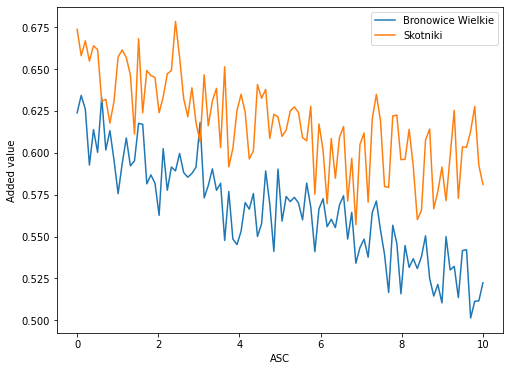

In [ ]:
n = 100
plt.figure(figsize=(8, 6))
xs = list(np.linspace(0, max_ASC, n))
b_points = results_b.added_value.values
s_points = results_s.added_value.values

plt.plot(xs, b_points, label='Bronowice Wielkie')
plt.plot(xs, s_points, label='Skotniki')

# plt.title(f'Added value = f(ASC)') 
plt.xlabel('ASC')
plt.ylabel('Added value')
plt.legend()
plt.savefig('images/asc_av_1.png', dpi=300)
plt.show()

In [42]:
bronowice = pd.read_csv("output/res_asc_av_b_100.csv", index_col=0)
bronowice['Area']='Bronowice'
bronowice['Prob of choosing feeder'] = bronowice['p_SUM']
bronowice['Reduction in waiting times for PT'] = bronowice['tw_PT_OD'] - bronowice['tw_PT_HD']
bronowice['Feeder attractiveness'] = bronowice['u_PT_OD']-bronowice['u_SUM_OD']
bronowice['Added value'] = np.log(np.exp(mu * bronowice['u_PT_OD']) +
                                  np.exp(mu * bronowice['u_SUM_OD']) -
                                  np.log(np.exp(mu * bronowice['u_PT_OD'])))

skotniki = pd.read_csv("output/res_asc_av_s_100.csv", index_col=0)
skotniki['Area']='Skotniki'
skotniki['Prob of choosing feeder'] = skotniki['p_SUM']
skotniki['Reduction in waiting times for PT'] = skotniki['tw_PT_OD'] - skotniki['tw_PT_HD']
skotniki['Feeder attractiveness'] = skotniki['u_PT_OD']-skotniki['u_SUM_OD']
skotniki['Added value'] = np.log(np.exp(mu * skotniki['u_PT_OD']) +
                                  np.exp(mu * skotniki['u_SUM_OD']) -
                                  np.log(np.exp(mu * skotniki['u_PT_OD'])))

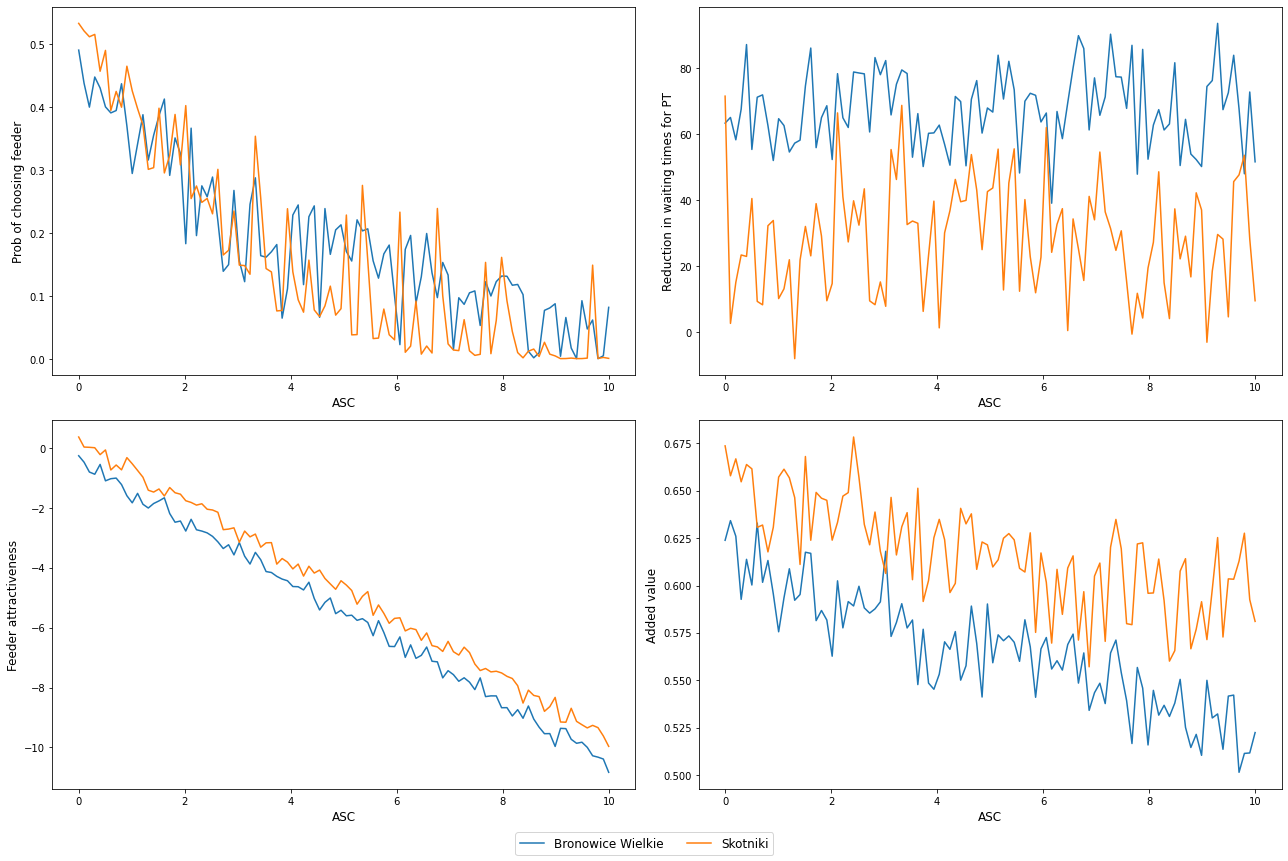

In [ ]:
cols_to_plot = skotniki.columns[-4:]
xs = list(np.linspace(0, max_ASC, n))
plt.figure(figsize=(18, 12))
lines = []

for idx, col in enumerate(cols_to_plot, start=1):
    plt.subplot(2, 2, idx)
    b_line, = plt.plot(xs, bronowice[col].values, label='Bronowice Wielkie')
    s_line, = plt.plot(xs, skotniki[col].values, label='Skotniki')
    
    # plt.title(f"{col} vs ASC")
    plt.xlabel("ASC", fontsize=12)
    plt.ylabel(col, fontsize=12)
    if idx == 1:
        lines.extend([b_line, s_line])


plt.figlegend(handles=lines, labels=['Bronowice Wielkie', 'Skotniki'], 
              loc='lower center', ncol=2, fontsize=12)

# plt.savefig('images/asc_vs_indicators_4.png', dpi=300)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()